In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import s3fs

In [10]:
#MY_BUCKET = "keithmoon"
#fs = s3fs.S3FileSystem(
#    client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"}
#)
#fs.get(f"{MY_BUCKET}/diffusion/conso_data.csv", '../')

In [11]:
conso_data = pd.read_csv('../conso_data.csv')
pd.set_option('display.max_columns', 60)

In [12]:
conso_data["nmonth"].tail()

2292    8.0
2293    8.0
2294    8.0
2295    8.0
2296    8.0
Name: nmonth, dtype: float64

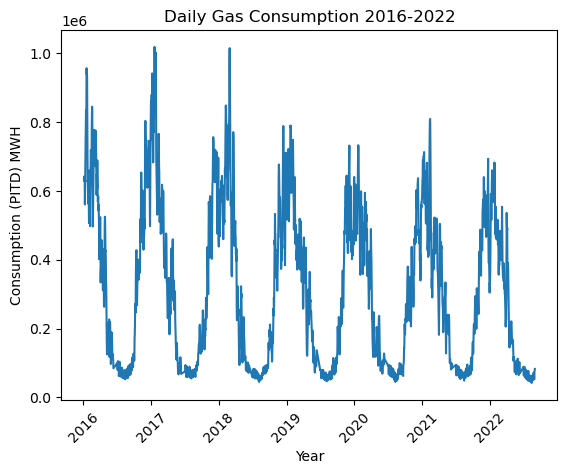

In [13]:
conso_data["date"] = pd.to_datetime(conso_data["date"])

# Plot the daily consumption
plt.plot(conso_data["date"], conso_data["pitd"])

# Title and labels
plt.title('Daily Gas Consumption 2016-2022')
plt.xlabel('Year')
plt.ylabel('Consumption (PITD) MWH')

# Set the x-axis to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to be every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show only the year

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

Le graphique révèle un phénomène de saisonnalité sur la période 2019-2022 marqué par des pics de consommations durant l'hiver et réciproquement des creux durant l'été. En effet, la consommation de gaz des ménages est décomposé en trois postes principaux selon les chiffres de l'ADEME en 2019 : le chauffage (80%), l'eau chaude (10%) et la cuisson (10%). Durant l'hiver le chauffage domine la consommation de gaz. Durant l'été, le chauffage et la chauffe de l'eau sont réduits, de ce fait, la cuisson dirige la consommation de gaz.
On remarque une différence marquée entre les hivers de 2016-2018 et 2019-2022. Une cause plausible est que les hivers sont plus chauds depuis 2019. On peut mesurer cela grâce aux Heating Degree Days, mesurant, à partir d'un seuil de 16.5°C le chauffage nécessaire en termes de degrés pour atteindre le seuil. Ainsi, si l'on somme sur le mois, on peut mesurer si le mois était plus froid d'une année à l'autre.

In [14]:
conso_data['date'] = pd.to_datetime(conso_data['date'])
base_temp = 16.5

conso_data['hdd'] = (base_temp - conso_data['tmoy']).clip(lower=0)

monthly_hdd = conso_data.set_index('date').resample('M')['hdd']

/tmp/ipykernel_26683/4055273609.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_hdd = conso_data.set_index('date').resample('M')['hdd']


/tmp/ipykernel_26683/13270003.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_hdd = conso_data.set_index('date').resample('M')['hdd'].sum()


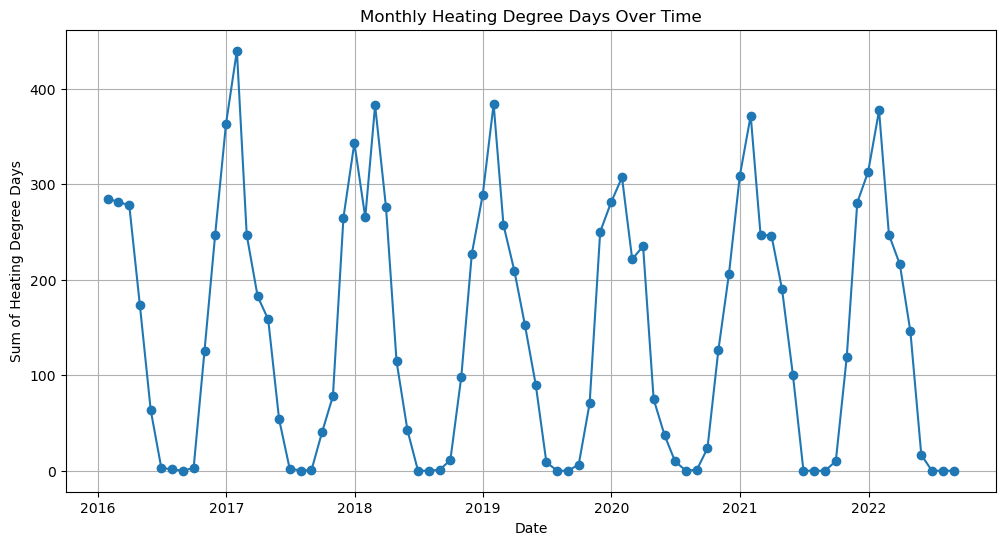

In [15]:
conso_data['date'] = pd.to_datetime(conso_data['date'])
base_temp = 16.5

conso_data['hdd'] = (base_temp - conso_data['tmoy']).clip(lower=0)

monthly_hdd = conso_data.set_index('date').resample('M')['hdd'].sum()

# Plot the monthly sum of HDD
plt.figure(figsize=(12, 6))
plt.plot(monthly_hdd.index, monthly_hdd.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sum of Heating Degree Days')
plt.title('Monthly Heating Degree Days Over Time')
plt.grid(True)
plt.show()

On observe que le nombre de HDD ne varie pas sensiblement entre les blocs 2016-2018 et 2019-2022. Ainsi l'explication d'hivers plus chauds ne semble pas être la bonne. un autre axe d'explication est la baisse progressive de la demande de gaz lié au passage à l'électrique ou à une meilleure isolation. On peut donc supposer qu'il y a simplement moins de clients. On décide alors de ne pas prendre en compte la période 2016-2018 et de commencer à 2019.

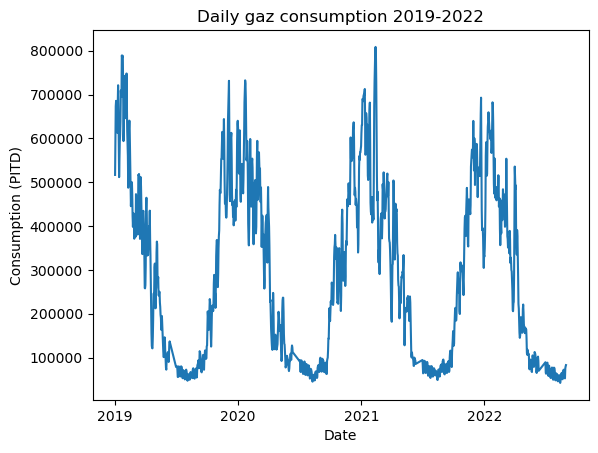

In [16]:
data_from_2019 = conso_data[conso_data["date"] >= '2019-01-01']

plt.plot(data_from_2019["date"], data_from_2019["pitd"])
plt.title('Daily gaz consumption 2019-2022')
plt.xlabel('Date')
plt.ylabel('Consumption (PITD)')


ax = plt.gca()
# Set major ticks to be at the start of each year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

On observe, comme précedemment, la différence marquée entre la consommation de gaz en été et en hiver

In [17]:
conso_data2 = conso_data

<Figure size 1000x600 with 0 Axes>

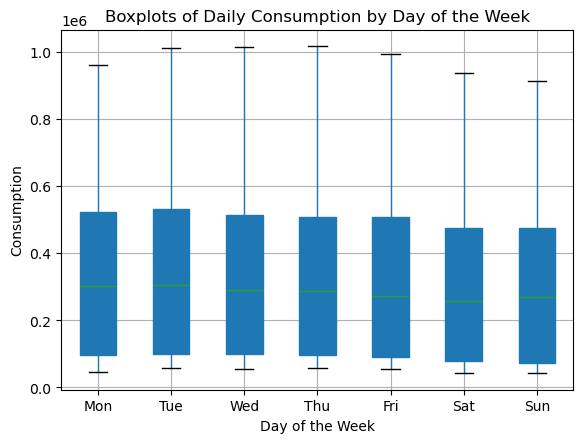

In [18]:
conso_data2['date'] = pd.to_datetime(conso_data2['date'])

# Extract day of the week (0 = Monday, 6 = Sunday)
conso_data2['day_of_week'] = conso_data2['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Define the correct order for days of the week (Monday to Sunday)
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Convert the 'day_of_week' to categorical with the correct order
conso_data2['day_of_week'] = pd.Categorical(conso_data2['day_of_week'], categories=range(0, 7), ordered=True)

# Group by 'day_of_week' and plot the boxplot
plt.figure(figsize=(10, 6))
conso_data2.boxplot(column='pitd', by='day_of_week', patch_artist=True)

# Add titles and labels
plt.title('Boxplots of Daily Consumption by Day of the Week')
plt.suptitle('')  # To remove the default title added by boxplot
plt.xlabel('Day of the Week')
plt.ylabel('Consumption')

# Set the x-ticks to correspond to the day names in the correct order
plt.xticks(ticks=range(1,8), labels=day_order)

# Show plot
plt.show()

#Similarités entre wed, thu, fri alors qu'on a un changement de conso le weeknd, les gens consomment moins ou différemment, catégories début semaine, milieu semaine et samedi dimanche, est ce que le calendrier est pertinent à garder ou est ce qu'il ne vaut pas mieux regrouper en groupes de jours. Regarder les boxplots sur les différents holidays, éventuellement grouper en holidays majeurs/mineurs. 
# Mettre l'accent sur les holidays car c'est la que le modèle se plante un peu, vraiment regarder les holidays par années. Plus de description sur tous les holidays en général à faire.

On observe une légère décroissance de la médiane de consommation de gaz au cours de la semaine. Cette décroissance fait ressortir deux catégories de jours de consommation. La semaine (lundi à jeudi) marqué par une consommation plus élevé que le weekend allongé (vendredi-dimanche). l'écart inter-quartile reste sensiblement le même tandis que les outliers durant le milieu de semaine sont plus élevés.

In [ ]:
import statsmodels.formula.api as smf
french_holidays = ["NewYearsDay","EasterMonday","LaborDay","FRFetDeLaVictoire1945","FRAscension","PentecostMonday","FRBastilleDay","FRAssumptionVirginMary","FRAllSaints","FRArmisticeDay","ChristmasDay"]
holiday_group_mapping = {
    "NewYearsDay": "XMas/NYE",
    "ChristmasDay": "XMas/NYE",
    "EasterMonday": "Easter",
    "PentecostMonday": "May Holidays",
    "FRAscension": "May Holidays",  
    "LaborDay": "May Holidays",
    "FRFetDeLaVictoire1945": "May Holidays",
    "FRBastilleDay": "Bastille",
    "FRArmisticeDay": "Armistice",
    "FRAssumptionVirginMary": "Ascension",
    "FRAllSaints": "Toussaint",
    "NotAHoliday": "NotAHoliday"}

filtered_data = conso_data[conso_data['public_holidays'].isin(french_holidays+["NotAHoliday"])].copy()

filtered_data['holiday_group'] = filtered_data['public_holidays'].map(holiday_group_mapping)

modele = smf.ols(formula='pitd ~ C(nmonth) - 1', data=filtered_data).fit() # OLS of PITD on nmonth converted to a categorical variable. No constant to have coefficients = mean of the month
filtered_data['pitd_deseason'] = modele.resid # the residuals give us the non seasonal gas consumption

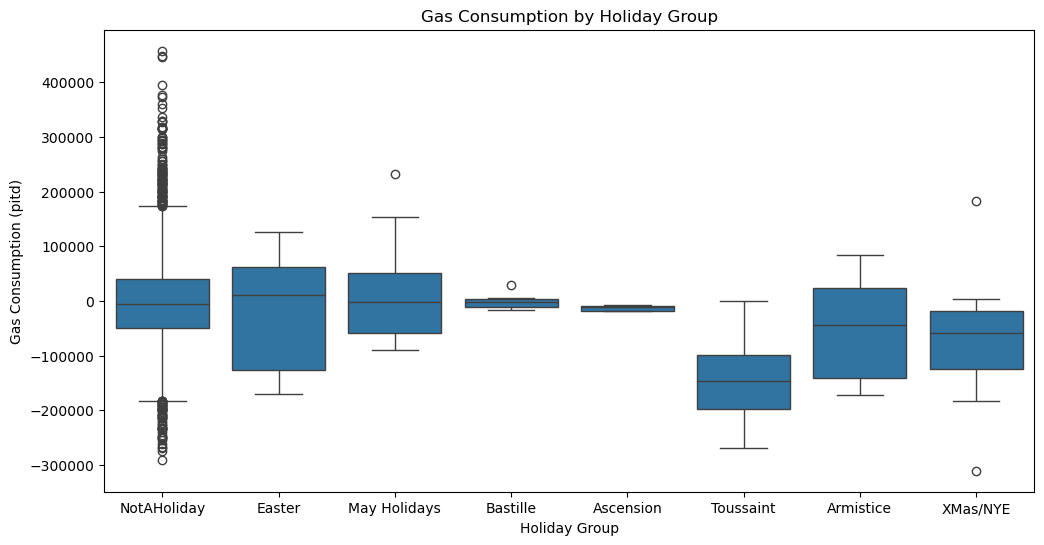

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='holiday_group', y='pitd_deseason', data=filtered_data)
plt.title('Gas Consumption by Holiday Group')
plt.xlabel('Holiday Group')
plt.ylabel('Gas Consumption (pitd)')
plt.show()

This boxplot shows gas consumption (after removing seasonality) for different types of days: normal days (“NotAHoliday”) vs. specific public holidays (Easter, May holidays, Bastille Day, etc.). May Holidays, Bastille Day, and Ascension behave much like normal days overall (mild period). Easter has a slightly higher median, it could be explain by large family meetings with heavy cooking and also the fact that Easter can fall during April (a rather cool month). In contrary, Toussaint shows a clear negative median, it can be explained by a lot of travelling due to children' holidays. Armistice is close to a normal day while Christmas and New Year's Eve are often sign of large family meetings with a lot of travel so less gas consumption even though it varies considerably.


<Figure size 1000x600 with 0 Axes>

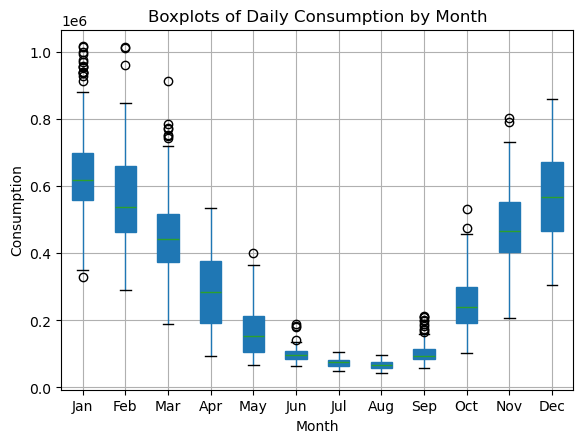

In [12]:
conso_data['date'] = pd.to_datetime(conso_data['date'])

conso_data['month'] = conso_data['date'].dt.month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
conso_data['month'] = pd.Categorical(conso_data['month'], categories=range(1, 13), ordered=True)
plt.figure(figsize=(10, 6))
conso_data.boxplot(column='pitd', by='month', patch_artist=True)

plt.title('Boxplots of Daily Consumption by Month')
plt.suptitle('')  # To remove the default title added by boxplot
plt.xlabel('Month')
plt.ylabel('Consumption')
plt.xticks(ticks=range(1, 13), labels=month_order)
plt.show()

# Regarder le jour de la semaine en fonction de période dans lequel on se trouve. On peut grouper par les saisons ou des périodes calendaires ou par mois, sinon ça mélange un peu tout et on ne voit pas grand chose.
# Boxplot par mois ok, 52 semaines pour croiser variables, scatterplot températures/conso, temp en x et conso en y, nuage de point sur ça. Dans ces nuages de points colorier les jours fériés avec une autre couleur pour montrer qu'ils sont spéciaux.
# Ajouter journées gaziers, jourénes gaz commencent à 6h jour j et va jusquà 3h du mat j+1. 

In [13]:
conso_data['public_holidays'] = conso_data['public_holidays'].apply(lambda x: 'NaH' if x in ['BoxingDay', 'GoodFriday'] else x)
rename_dict = {
    'ChristmasDay': 'XMas', 'EasterMonday': 'Easter', 'FRAllSaints': 'AS', 'FRArmisticeDay': 'Arm',
    'FRAscension': 'Asc', 'FRAssumptionVirginMary': 'Assump', 'FRBastilleDay': 'Bast', 
    'FRFetDeLaVictoire1945': '1945', 'LaborDay': 'Lab', 'NewYearsDay': 'NY', 
    'NotAHoliday': 'NaH', 'PentecostMonday': 'Pent'
}

<Figure size 1600x1200 with 0 Axes>

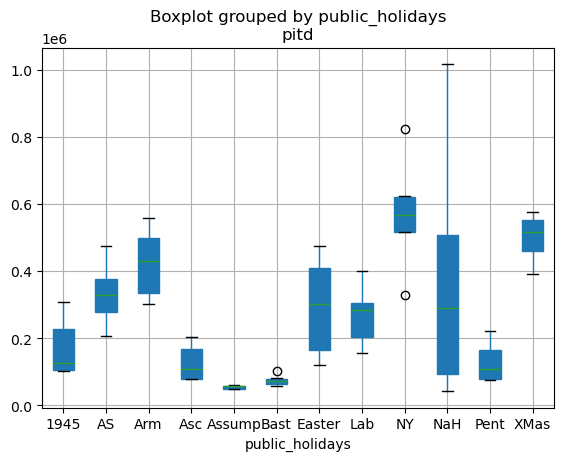

In [14]:
conso_data['public_holidays'] = conso_data['public_holidays'].apply(lambda x: rename_dict.get(x, x))
plt.figure(figsize=(16, 12))  
conso_data.boxplot(column='pitd', by='public_holidays', patch_artist=True)
plt.show()
# faire catégorie holiday etat, locaux, religion

Text(0.5, 0, 'Is a Holiday')

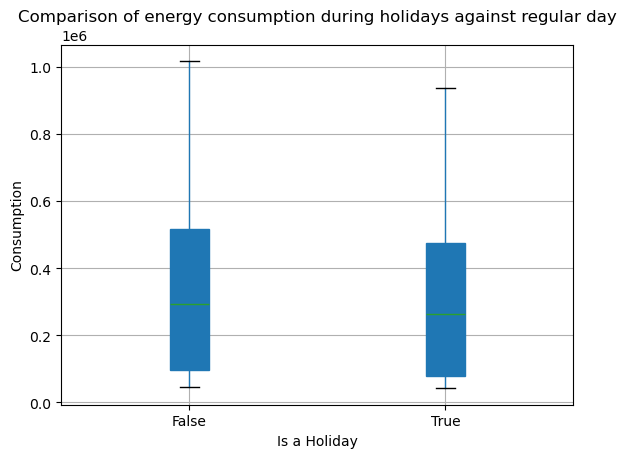

In [15]:
conso_data.boxplot(column='pitd', by='isHoliday', patch_artist=True)
plt.title('Comparison of energy consumption during holidays against regular day')
plt.suptitle('')
plt.ylabel('Consumption')
plt.xlabel('Is a Holiday')
# Pas super intéressant...
# Si on doit regarder la stat desc, on peut regarder sur google images comment des gens plot leurs trucs. 
# à mettre dans annexe - secondaire

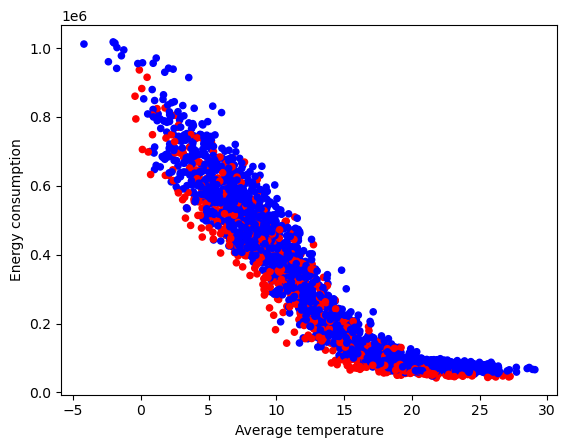

In [16]:
conso_data['color'] = conso_data['isHoliday'].apply(lambda x: 'red' if x else 'blue')

conso_data.plot.scatter(x='tmoy', y='pitd', c=conso_data['color'], xlabel='Average temperature', ylabel='Energy consumption')

plt.show()
# C'est la en fait il faut que je colore les holidays, j'ai pris tmoy ici par contre il y a aussi t_eff etc...
# Tracer une droite à 16.5°C pour marquer la différence de conso passé ce cap. Avant 16.5 il y a cuisine chauffage d'au et en plus le besoin de chauffage.

Text(0, 0.5, 'Energy consumption')

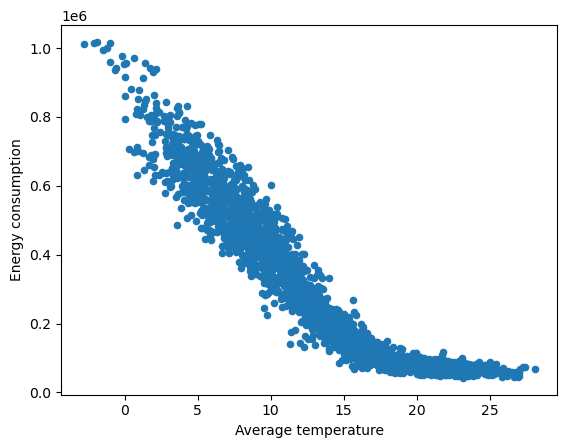

In [17]:
conso_data.plot.scatter('teff_optim', 'pitd')
plt.xlabel('Average temperature')
plt.ylabel('Energy consumption')
# Quasi pareil mais j'ai regardé sur teff cette fois. 
# Ajouter samedi dimanche avec une autre couleur, en gros jours travaillés et jours non travaillés pour avoir un code couleur différent. 
# Donc je colore les holidays différemmetn aussi ? A tester. Pas bcp nombreux donc osef sans doute. sam/dim ou holidays.

/tmp/ipykernel_16348/3285107626.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = conso_data.pivot_table(values='pitd', index='day_of_week', columns='month', aggfunc='mean')


<Figure size 1200x800 with 0 Axes>

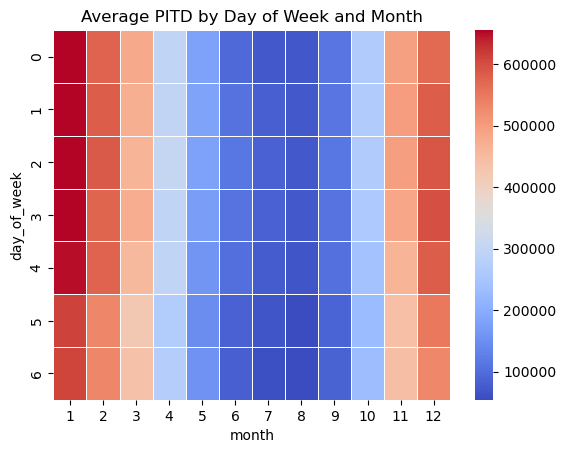

<Figure size 1200x800 with 0 Axes>

In [18]:
pivot_table = conso_data.pivot_table(values='pitd', index='day_of_week', columns='month', aggfunc='mean')
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Average PITD by Day of Week and Month')
plt.figure(figsize=(12, 8))  
# Une heatmap pour la conso moyenne sur les jours et les mois. 
# à rattacher au boxplot 

In [19]:
print(conso_data['pitd'].describe())

count    2.297000e+03
mean     3.225228e+05
std      2.292691e+05
min      4.212710e+04
25%      9.415002e+04
50%      2.875569e+05
75%      5.052268e+05
max      1.017746e+06
Name: pitd, dtype: float64


In [20]:
conso_data['public_holidays']

0       NaH
1       NaH
2       NaH
3       NaH
4       NaH
       ... 
2292    NaH
2293    NaH
2294    NaH
2295    NaH
2296    NaH
Name: public_holidays, Length: 2297, dtype: object

In [21]:
matrix_var = ['pitd', 'li', 'target', 'below16.5', 'isWeekday', 'isBizday', 'noel.structural', 'public_holidays', 'ponts_publics']

In [22]:
conso_data['public_holidays'] = conso_data['public_holidays'].apply(lambda x: 0 if x == 'NotAHoliday' else 1)
corr_matrix = conso_data[matrix_var].corr()
# La j'ai regardé un peu les corrélations pour voir ce qu'il se passait.

In [23]:
corr_matrix

,pitd,li,target,below16.5,isWeekday,isBizday,noel.structural,public_holidays,ponts_publics
pitd,1.000000,0.312851,0.081696,0.709482,0.063523,0.063523,0.169918,NaN,-0.038942
li,0.312851,1.000000,0.060113,0.352103,0.072157,0.072157,0.150407,NaN,0.001093
target,0.081696,0.060113,1.000000,0.035897,0.195424,0.195424,0.034775,NaN,0.010732
below16.5,0.709482,0.352103,0.035897,1.000000,0.009440,0.009440,0.116688,NaN,-0.043132
isWeekday,0.063523,0.072157,0.195424,0.009440,1.000000,1.000000,-0.006810,NaN,0.060668
isBizday,0.063523,0.072157,0.195424,0.009440,1.000000,1.000000,-0.006810,NaN,0.060668
noel.structural,0.169918,0.150407,0.034775,0.116688,-0.006810,-0.006810,1.000000,NaN,0.093001
public_holidays,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ponts_publics,-0.038942,0.001093,0.010732,-0.043132,0.060668,0.060668,0.093001,NaN,1.000000


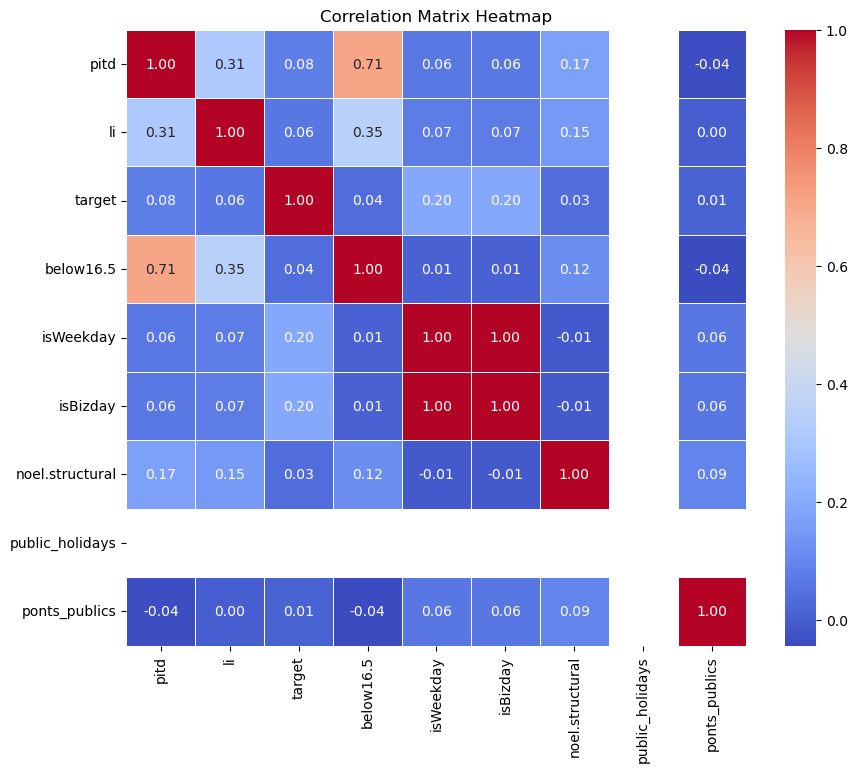

In [ ]:
plt.figure(figsize=(10, 8))  # Optional: adjust figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)

# Add title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()
# Prendre uniquement les variables numériques et enlever les variables binaires parce que colinéarité sinon entre binaires.

In [25]:
# C'est tout. 
# Pour résumer, variables sont explicatives on a vu les noms, il faut ajuster les graphiques avec les consignes au dessus, code couleurs, commentaires etc...
# Tout ça pour le chapitre stat desc de data, faire le petit ex de chaines de markov sur les deux états. Essayer de faire un ex avec 4 états. 
# Parler des chaines de markov et dire que c'est une variable explicative, on n'impose rien par convention.
# Dire qu'on a pas besoin de croiser les variables car catboost le fait.
# has_time pour les time series, si on lui dit pas qu'il y a time il dire au hasard les points, à tester. 